In [1]:
from collections.abc import Iterable
import os

from adjustText import adjust_text
from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import latex
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import os
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from networkx import kamada_kawai_layout

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [2]:
#Optional import if you want to open figures in a separate window, add %matplotlib qt to top of any code box if you want figures to open in a separate window 
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"

# Figure 3: Atlas visualization

Figure 3 contains three ways to visualize an atlas of neuron means and covariances. First, we train the statistical atlas on the corpus of data and generate point clouds aligned to the common atlas space. Trained atlases and aligned point clouds can be downloaded from this link https://ucsf.box.com/s/8kbdfywefcfsn4pfextrzcr25az1vmuj. Download this folder and move it into the root of this repository. You can also run the StatAtlas code provided in this repository to generate new atlases and aligned point clouds.

In [3]:
NWB_atlas = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_match_full_nosplit.pkl') #Load the fully trained Atlas

In [4]:
def plot_atlas_unrolled(atlas, vRecenter = [0,0,0]):
    """df needs: x/y/zcyl, ganglion, h, theta """

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(6)

    ax1 = plt.subplot2grid(shape=(10,6), loc=(0,0), colspan=6, rowspan=10)
    atlas_df = atlas.get_df(vRecenter=vRecenter)

    atlas_df = atlas_df.sort_values(by=['ID'], ignore_index=True)

    ganglia = sorted(atlas_df['ganglion'].unique())

    OBJECTS = []
    for g in ganglia:
        dfg = atlas_df[atlas_df['ganglion'] == g]
        OBJECTS.append(ax1.plot(dfg['theta'], dfg['h'], 'o', lw=0, label=g, markerfacecolor='None'))

    OBJECTS = [object for l in OBJECTS for object in l]
    ax1.axvspan(-135, -45, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvspan(45, 135, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvline(-180, ls='--', color='grey')
    ax1.axvline(180, ls='--', color='grey')
    ax1.set_xlabel('theta')
    ax1.set_ylabel('Distance along AP axis')
    ax1.legend(fontsize=16)

    TEXTS = []
    for i, row in atlas_df.iterrows():
        x = row['theta']
        y = row['h']
        TEXTS.append(ax1.text(x,y, row['ID'], fontsize=10))

    adjust_text(
        TEXTS,
        arrowprops = dict(arrowstyle="-", color='gray'),
        time_lim = 5,
        force_text = (0.3,0.3),
        ensure_inside_axes = False,
        expand_axes = True,
        ax=ax1
    )

    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)


    plt.tight_layout()
    plt.show()

In [11]:
import networkx as nx

def plot_atlas_2d(atlas, k=3):
    plt.rcParams.update({'font.size':16})

    labels = atlas.neurons

    xyz_sigma = atlas.xyzsigma
    rgb_sigma = atlas.rgbsigma

    xyz_mu = atlas.xyzmu
    rgb_mu = atlas.rgbmu

    fig, axs = plt.subplots(2,1,sharex=True)

    TEXTSxy = []
    TEXTSxz = []
    for i in range(xyz_sigma.shape[2]):
        atlas.draw_ellipse(xyz_mu[i,[0,1]],xyz_sigma[0:2,0:2,i],atlas.atlas_color[i,:3], std_devs=1, ax=axs[1],line_width=2)
        atlas.draw_ellipse(xyz_mu[i,[0,2]],xyz_sigma[[0,2],:,i][:,[0,2]],atlas.atlas_color[i,:3], std_devs = 1, ax=axs[0],line_width=2)
        
        x = xyz_mu[i,0]
        y = xyz_mu[i,1]
        z = xyz_mu[i,2]

        color = atlas.atlas_color[i,:3]

        #TEXTSxy.append(axs[1].text(x,y, df_original.loc[i,'ID'], color=color, fontsize=5))
        #TEXTSxz.append(axs[0].text(x,z, df_original.loc[i,'ID'], color=color, fontsize=5))

    label_pos_xy = xyz_mu[:,[0,1]]
    label_pos_xz = xyz_mu[:,[0,2]]
    colors = atlas.atlas_color[:,:3]

    def repel_labels(ax, x, y, labels, k=0.1): #From https://stackoverflow.com/questions/14938541/how-to-improve-the-label-placement-in-scatter-plot
        G = nx.DiGraph()
        data_nodes = []
        init_pos =  {}
        for xi, yi, label in zip(x,y,labels):
            data_str = 'data_{0}'.format(label)
            G.add_node(data_str)
            G.add_node(label)
            G.add_edge(label, data_str)
            data_nodes.append(data_str)
            init_pos[data_str] = (xi, yi)
            init_pos[label] = (xi, yi)

        pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

        pos_after = np.vstack([pos[d] for d in data_nodes])
        pos_before = np.vstack([init_pos[d] for d in data_nodes])
        scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0],1)
        scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1],1)
        shift = np.array([shift_x, shift_y])
        for key, val in pos.items():
            pos[key] = (val*scale) + shift

        for i, (label, data_str) in enumerate(G.edges()):
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data', fontsize= 'xx-small', color=colors[i,:],
                        arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0, connectionstyle='arc3', color=colors[i,:]))

        all_pos = np.vstack([value for value in pos.values()])
        x_span, y_span = np.ptp(all_pos, axis=0)
        mins = np.min(all_pos-x_span*0.15, 0)
        maxs = np.max(all_pos+y_span*0.15, 0)
        ax.set_xlim([mins[0], maxs[0]])
        ax.set_ylim([mins[1], maxs[1]])

    repel_labels(axs[0], label_pos_xz[:,0], label_pos_xz[:,1], labels, k=k)
    repel_labels(axs[1], label_pos_xy[:,0], label_pos_xy[:,1], labels, k=k)
        
    #axs[0].set_aspect('equal')
    axs[0].grid()
    axs[0].set_ylabel('')
    axs[0].set_ylim((-30,5))
    axs[0].invert_yaxis()
    axs[0].set_yticks([])
    axs[0].set_xlim((-25,150))
    axs[0].autoscale_view()

    #axs[1].set_aspect('equal')
    axs[1].grid()
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_ylim((-5,30))
    axs[1].set_xlim((-25,170))
    axs[1].autoscale_view()
    
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)

    axs[0].grid(False)
    axs[1].grid(False)

    plt.show()


In [6]:
def plot_atlas_color(atlas):
    rgb_mu = atlas.rgbmu
    rgb_sigma = atlas.rgbsigma

    fig, axs = plt.subplots(1,3)

    for n in range(rgb_sigma.shape[2]):
        
        rgl1, rgl2, rgtheta = covar_to_coord(rgb_sigma[[0,1],:,n][:,[0,1]])
        rbl1, rbl2, rbtheta = covar_to_coord(rgb_sigma[[0,2],:,n][:,[0,2]])
        gbl1, gbl2, gbtheta = covar_to_coord(rgb_sigma[[1,2],:,n][:,[1,2]])

        rmu = rgb_mu[n, 0]
        gmu = rgb_mu[n, 1]
        bmu = rgb_mu[n, 2]
        
        #looking at only half a std to make it easier to visualize 
        rg_ellipse = Ellipse((rmu,gmu), width =rgl1*2, height = rgl2*2, angle=rgtheta*180/np.pi, alpha=0.1, edgecolor='orange', facecolor='orange')
        axs[0].add_patch(rg_ellipse)
        rb_ellipse = Ellipse((rmu, bmu), width =rbl1*2, height = rbl2*2, angle=rbtheta*180/np.pi, alpha=0.1, edgecolor='magenta', facecolor='magenta')
        axs[1].add_patch(rb_ellipse)
        gb_ellipse = Ellipse((gmu, bmu), width =gbl1*2, height = gbl2*2, angle=gbtheta*180/np.pi, alpha=0.1, edgecolor='cyan', facecolor='cyan')
        axs[2].add_patch(gb_ellipse)

    axs[0].set_xlabel('Z-score red')
    axs[0].set_ylabel('Z-score green')
    axs[1].set_xlabel('Z-score red')
    axs[1].set_ylabel('Z-score blue')
    axs[2].set_xlabel('Z-score green')
    axs[2].set_ylabel('Z-score blue')

    for ax in axs:
    #    ax.set_aspect('equal')
        #ax.set_xlim(-5,35)
        #ax.set_ylim(-5,35)
        ax.autoscale_view()
        ax.set_xticks([])
        ax.set_yticks([])
    
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)
    
    plt.show()

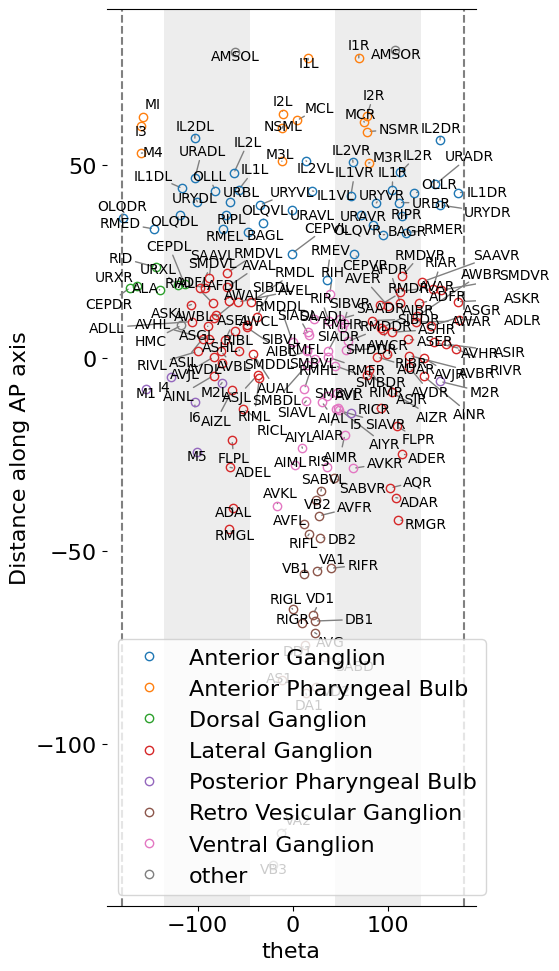

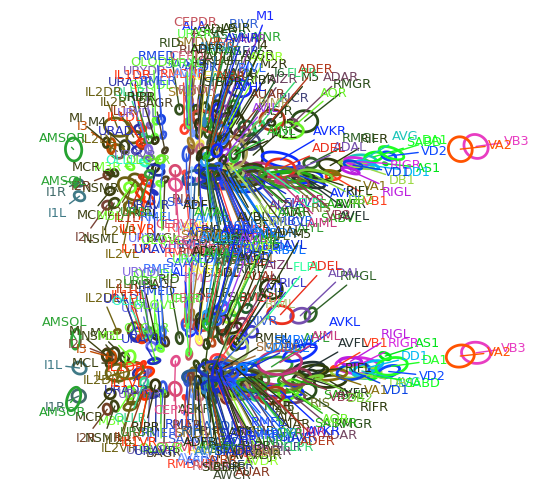

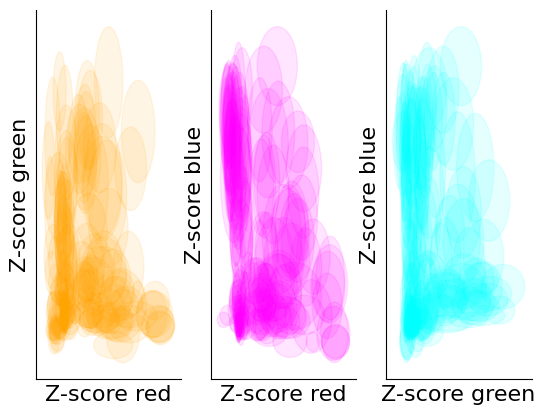

In [12]:
plot_atlas_unrolled(NWB_atlas, vRecenter=[60,10,-10])
plot_atlas_2d(NWB_atlas, k = 3) #Parameter k defines how far labels are pushed away from the neuron location. Use automatic placement for rough alignment and then adjust manually in illustrator/photoshop/etc.
plot_atlas_color(NWB_atlas)